In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')
import astropy.stats as stats
from scipy.signal import savgol_filter

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
expNum = DESutils.createBandDict("/data3/garyb/tno/y6/zone134")[1]["i"][0]
dC = GPRutils.loadFITS(f"/home/fortino/GPRSolutions/zone134/GPR.{expNum}.?RC.fits")
dC.summarize(plot=False)

#####------361582 i------#####
Fitted von Kármán kernel parameters:
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
110.6607377    1.6261553      0.0359941      -0.0212567     0.0963493      
    xi0: 101.526 ± 2.039
    xif: 14.906 ± 0.817
    Reduction: 6.811 ± 0.398

Final von Kármán kernel parameters:
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
215.8798051    1.5231584      0.0234323      -0.0213215     0.0080798      
    xi0: 101.526 ± 2.039
    xif: 7.218 ± 0.703
    Reduction: 14.065 ± 1.398



In [3]:
mask = dC.TV["Subset A"] & dC.TV["Maskf"]
x = dC.TV[mask]["X"]
y = dC.TV[mask]["Y"]

# Raw Data
dx_raw = dC.TV[mask]["dX"]
dy_raw = dC.TV[mask]["dY"]

# Fitted Data
dx_fit = dC.TV[mask]["fbar_s dX fC"]
dy_fit = dC.TV[mask]["fbar_s dY fC"]

# Optimized Data
dx_gpr = dC.TV[mask]["fbar_s dX"]
dy_gpr = dC.TV[mask]["fbar_s dY"]

# Residual Data
dx_res = dx_raw - dx_gpr
dy_res = dx_raw - dx_gpr

In [62]:
nBins = 100
rmax = 0.50*u.deg

nData = len(x)
if nBins % 2 == 0:
    nBins += 1
bins = np.around(np.linspace(-rmax, rmax, nBins).to(u.arcmin), 1).value

ticks = np.array([
    np.argmin(np.abs(bins - (-20*u.arcmin).value)),
    np.argmin(np.abs(bins - (-10*u.arcmin).value)),
    np.argmin(np.abs(bins - (0*u.arcmin).value)),
    np.argmin(np.abs(bins - (10*u.arcmin).value)),
    np.argmin(np.abs(bins - (20*u.arcmin).value))
])

ticklabels = bins[ticks]
ticklabels = [-20, -10, 0, 10, 20]

In [5]:
xiplus_raw = GPRutils.calcCorrelation2D(
    x, y, dx_raw, dy_raw, rmax=rmax, nBins=nBins)[0]

xiplus_fit = GPRutils.calcCorrelation2D(
    x, y, dx_fit, dy_fit, rmax=rmax, nBins=nBins)[0]

xiplus_gpr = GPRutils.calcCorrelation2D(
    x, y, dx_gpr, dy_gpr, rmax=rmax, nBins=nBins)[0]

xiplus_res = GPRutils.calcCorrelation2D(
    x, y, dx_res, dy_res, rmax=rmax, nBins=nBins)[0]

In [6]:
dx = (rmax / (nBins / 2)).to(u.deg).value
xx = np.arange(-nBins / 2, nBins / 2) * dx
xx, yy = np.meshgrid(xx, xx)

ttt_fit = vk.TurbulentLayer(
    variance=dC.fitCorrParams[0],
    outerScale=dC.fitCorrParams[1],
    diameter=dC.fitCorrParams[2],
    wind=(dC.fitCorrParams[3], dC.fitCorrParams[4]))
K_fit = ttt_fit.getCuv(xx, yy)
Kplus_fit = K_fit[:, :, 0, 0] + K_fit[:, :, 1, 1]

ttt_gpr = vk.TurbulentLayer(
    variance=dC.params[0],
    outerScale=dC.params[1],
    diameter=dC.params[2],
    wind=(dC.params[3], dC.params[4]))
K_gpr = ttt_gpr.getCuv(xx, yy)
Kplus_gpr = K_gpr[:, :, 0, 0] + K_gpr[:, :, 1, 1]

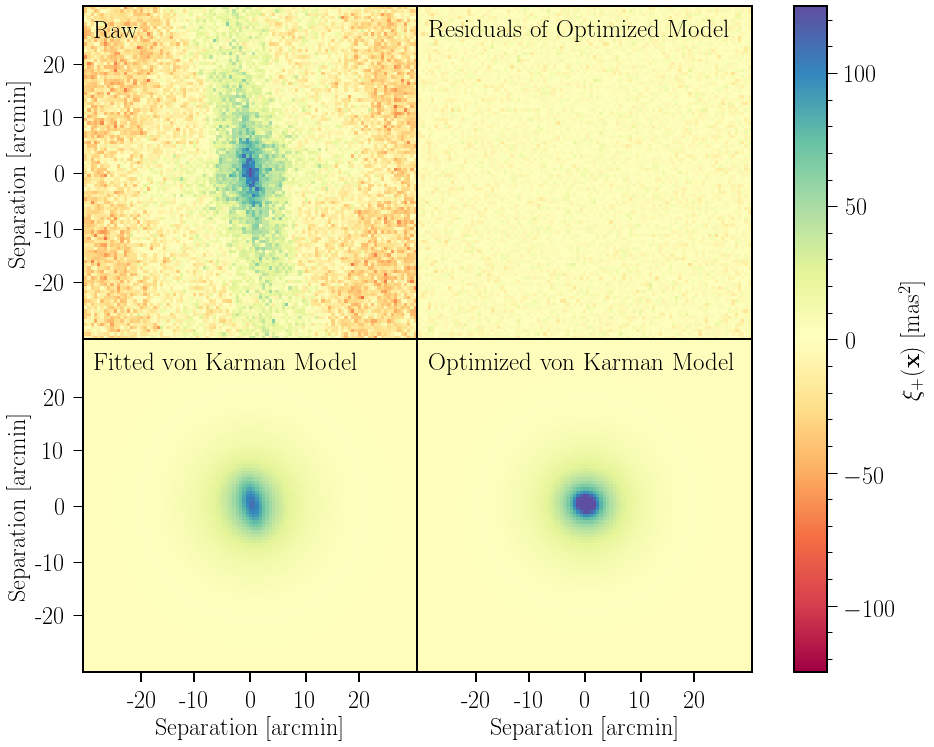

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(15, 12.25))
fig.subplots_adjust(hspace=0, wspace=0)

axes[0, 0].set_ylabel("Separation [arcmin]")
axes[1, 0].set_ylabel("Separation [arcmin]")

axes[1, 0].set_xlabel("Separation [arcmin]")
axes[1, 1].set_xlabel("Separation [arcmin]")

axes[0, 0].set_yticks([], minor=True)
axes[1, 0].set_yticks([], minor=True)
axes[0, 1].set_yticks([], minor=True)
axes[1, 1].set_yticks([], minor=True)

axes[0, 0].set_yticks(ticks)
axes[1, 0].set_yticks(ticks)
axes[0, 1].set_yticks([])
axes[1, 1].set_yticks([])

axes[0, 0].set_yticklabels(ticklabels)
axes[1, 0].set_yticklabels(ticklabels)
axes[0, 1].set_yticklabels([])
axes[1, 1].set_yticklabels([])

axes[0, 0].set_xticks([], minor=True)
axes[1, 0].set_xticks([], minor=True)
axes[0, 1].set_xticks([], minor=True)
axes[1, 1].set_xticks([], minor=True)

axes[0, 0].set_xticks([])
axes[1, 0].set_xticks(ticks)
axes[0, 1].set_xticks([])
axes[1, 1].set_xticks(ticks)

axes[0, 0].set_xticklabels([])
axes[1, 0].set_xticklabels(ticklabels)
axes[0, 1].set_xticklabels([])
axes[1, 1].set_xticklabels(ticklabels)

kwargs = {
    "xy": (2, 70),
    "xycoords": "data",
    "textcoords": "offset points",
    "fontsize": 25
}

axes[0, 0].annotate("Raw", **kwargs)
axes[0, 1].annotate("Residuals of Optimized Model", **kwargs)
axes[1, 0].annotate("Fitted von Karman Model", **kwargs)
axes[1, 1].annotate("Optimized von Karman Model", **kwargs)

vmin = -125*u.mas**2
vmax = 125*u.mas**2

im_raw = axes[0, 0].imshow(
    xiplus_raw,
    origin="lower",
    cmap="Spectral",
    interpolation="nearest",
    vmin=vmin.to(u.mas**2).value,
    vmax=vmax.to(u.mas**2).value)

im_res = axes[0, 1].imshow(
    xiplus_res,
    origin="lower",
    cmap="Spectral",
    interpolation="nearest",
    vmin=vmin.to(u.mas**2).value,
    vmax=vmax.to(u.mas**2).value)

im_fit = axes[1, 0].imshow(
    Kplus_fit,
    origin="lower",
    cmap="Spectral",
    interpolation="nearest",
    vmin=vmin.to(u.mas**2).value,
    vmax=vmax.to(u.mas**2).value)

im_gpr = axes[1, 1].imshow(
    Kplus_gpr,
    origin="lower",
    cmap="Spectral",
    interpolation="nearest",
    vmin=vmin.to(u.mas**2).value,
    vmax=vmax.to(u.mas**2).value)

# axes[0, 0].set_aspect("equal", )
# axes[1, 0].set_aspect("equal", )
# axes[0, 1].set_aspect("equal", )
# axes[1, 1].set_aspect("equal", )

axes[0, 0].set_aspect("equal", adjustable="datalim", anchor="C")
axes[1, 0].set_aspect("equal", adjustable="datalim", anchor="C")
axes[0, 1].set_aspect("equal", adjustable="datalim", anchor="C")
axes[1, 1].set_aspect("equal", adjustable="datalim", anchor="C")

cbar = fig.colorbar(im_raw, ax=fig.get_axes())
cbar.set_label(r"$\xi_+(\textbf{x})$ [mas$^2$]", rotation=90)

plt.savefig("/home/fortino/2dxi.pdf")
plt.show()